
MNIST Digit Classifier Demo

This notebook demonstrates how to train and use the MNIST digit classifier model.


In [47]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)


In [48]:
from torch.utils.data import DataLoader

loaders = {
  'train': DataLoader(train_data, batch_size=100, shuffle=True, num_workers=1),
  'test': DataLoader(test_data, batch_size=100, shuffle=True, num_workers=1)
}

In [49]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class MNISTClassifier(nn.Module):
  def __init__(self):
    super(MNISTClassifier, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.conv2_drop = nn.Dropout2d(0.25)
    self.fc1 = nn.Linear(320, 50)
    self.fc_drop = nn.Dropout(0.5)
    self.fc2 = nn.Linear(50, 10)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))

    x = x.view(-1, 320)

    x = F.relu(self.fc1(x))
    # Dropout for regularisation
    x = F.dropout(x, training=self.training)

    # Output layer (logits)
    x = self.fc2(x)

    # Return log softmax probabilities
    return F.log_softmax(x, dim=1)
    


In [50]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MNISTClassifier().to(device)

optimiser = optim.Adam(model.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss()

def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(loaders['train']):
    data, target = data.to(device), target.to(device)
    optimiser.zero_grad()
    output = model(data)
    loss = loss_fn(output, target)
    loss.backward()
    optimiser.step()
    if batch_idx % 20 == 0:
      print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(loaders["train"].dataset)} '
            f'({100. * batch_idx / len(loaders["train"]):.0f}%)]\tLoss: {loss.item():.6f}')

def test():
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in loaders['test']:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += loss_fn(output, target).item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(loaders['test'].dataset)
  print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(loaders["test"].dataset)} '
        f'({100. * correct / len(loaders["test"].dataset):.0f}%)')


In [51]:
for epoch in range(1, 11):
  train(epoch)
  test()



Train Epoch: 1 [0/60000 (0%)]	Loss: 2.290995
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.098032
Train Epoch: 1 [4000/60000 (7%)]	Loss: 1.693058
Train Epoch: 1 [6000/60000 (10%)]	Loss: 1.236168
Train Epoch: 1 [8000/60000 (13%)]	Loss: 0.992083
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.672233
Train Epoch: 1 [12000/60000 (20%)]	Loss: 0.634786
Train Epoch: 1 [14000/60000 (23%)]	Loss: 0.579843
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.574331
Train Epoch: 1 [18000/60000 (30%)]	Loss: 0.621012
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.513407
Train Epoch: 1 [22000/60000 (37%)]	Loss: 0.629504
Train Epoch: 1 [24000/60000 (40%)]	Loss: 0.365041
Train Epoch: 1 [26000/60000 (43%)]	Loss: 0.383207
Train Epoch: 1 [28000/60000 (47%)]	Loss: 0.316441
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.488146
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.329916
Train Epoch: 1 [34000/60000 (57%)]	Loss: 0.577825
Train Epoch: 1 [36000/60000 (60%)]	Loss: 0.419780
Train Epoch: 1 [38000/60000 (63%)]	Loss: 0.346978
Train Epoch

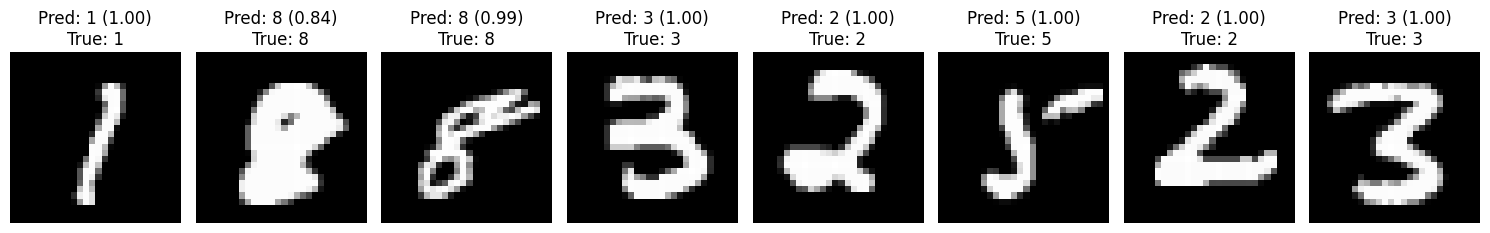

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# Set model to evaluation mode
model.eval()

# Get a batch of test data
test_examples = iter(loaders['test'])
test_images, test_labels = next(test_examples)

# Select 5 random images
indices = np.random.choice(range(len(test_images)), size=8, replace=False)
test_samples = [test_images[i] for i in indices]
test_sample_labels = [test_labels[i] for i in indices]

# Move samples to device
device_samples = [sample.unsqueeze(0).to(device) for sample in test_samples]

# Make predictions
with torch.no_grad():
    outputs = [model(sample) for sample in device_samples]
    predictions = [output.argmax(dim=1, keepdim=True).item() for output in outputs]
    confidences = [torch.exp(output)[0][pred].item() for output, pred in zip(outputs, predictions)]

# Display the images and predictions
fig, axes = plt.subplots(1, 8, figsize=(15, 3))

for i in range(8):
    # Display image (convert to numpy for matplotlib)
    img_display = test_samples[i].squeeze().numpy()
    axes[i].imshow(img_display, cmap='gray')
    
    # Set title with prediction and ground truth
    pred_digit = predictions[i]
    confidence = confidences[i]
    true_label = test_sample_labels[i].item()
    axes[i].set_title(f"Pred: {pred_digit} ({confidence:.2f})\nTrue: {true_label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()